# 주식 거래 시스템 구축(융복합 AI - 오희주)

## 1. UI 

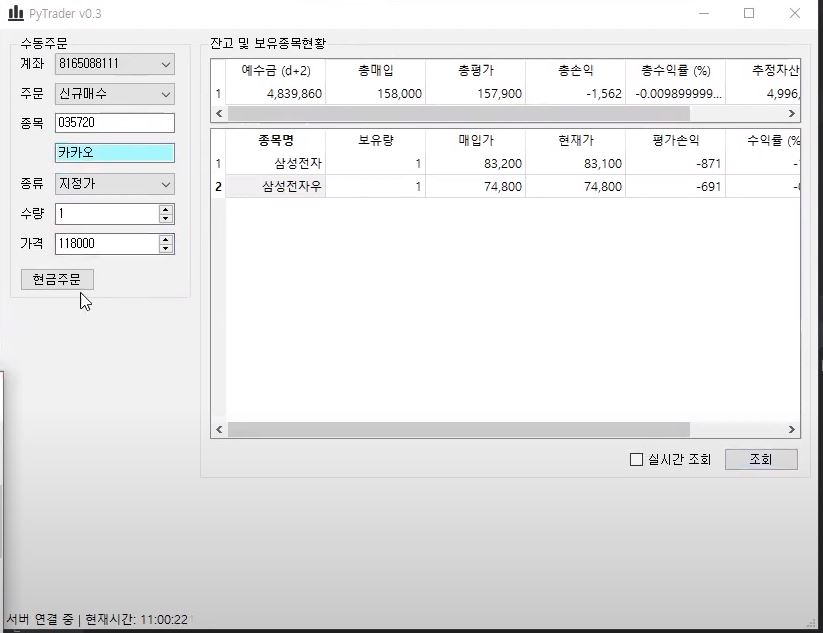

In [1]:
from IPython.display import Image
Image("pytraderPhoto2.jpg")

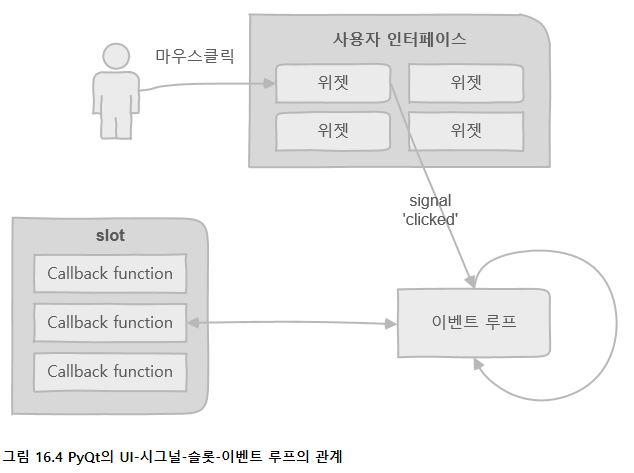

In [2]:
Image("PyQt의 UI_시그널_슬롯_이벤트 루프의 관계.jpg")

### < 핵심 구성 >
#### (1) 사용자 인터페이스: 화면에 출력되는 UI 부분, PyQt가 기본적으로 제공하는 위젯(Widget)으로 클래스의 객체를 생성할 수 있음
#### (2) 이벤트 루프: PyQt의 QApplication 객체에서 exec_ 메서드를 호출해 이벤트 루프를 생성
#### (3) 이벤트를 처리할 메서드: 버튼과 같은 위젯을 클릭하면, 해당 위젯은 'clicked'라는 시그널을 발생. 시그널이 발생했을 때 호출되는 메서드를 구현해야함. PyQt에서는 특정 시그널이 발생했을 때, 호출되는 함수 또는 메서드를 슬롯(slot)이라함


###  < GUI 프로그램의 전반적인 실행 흐름 >
#### (1) 사용자가 버튼 위젯을 클릭
#### (2) 'clicked'라는 시그널 발생
#### (2) 이벤트 루프는 해당 시그널에 등록된 슬롯을 호출함으로써 사용자가 발생시킨 이벤트를 처리. (프로그램 종료 시그널 보내기 전까지는 계속 위와 같은 방식으로 시그널과 연결된 슬롯을 호출함으로써 이벤트를 처리함)

# 2. pytrader.py

```python
import sys
from PyQt5.QtWidgets import *
from PyQt5.QtCore import *
from PyQt5 import uic
from Kiwoom import *
import time

form_class = uic.loadUiType("pytrader.ui")[0] # pytrader.ui 실행

class MyWindow(QMainWindow, form_class):
    # QMainWindow: QWidget 상속하는 클래스(위젯 사용할 수 있도록), form_class: pytrader.ui
    def __init__(self):
        super().__init__()
        self.setupUi(self)

        self.kiwoom = Kiwoom() # Kiwoom 인스턴스 생성
        self.kiwoom.comm_connect() # 로그인

        self.timer = QTimer(self)
        self.timer.start(1000)
        self.timer.timeout.connect(self.timeout)

        self.timer2 = QTimer(self)
        self.timer2.start(1000 *10)
        self.timer2.timeout.connect(self.timeout2)

        accouns_num = int(self.kiwoom.get_login_info("ACCOUNT_CNT")) # 보유계좌 갯수 (ex. 2)
        accounts = self.kiwoom.get_login_info("ACCNO") # 구분자 ';'로 연결된 보유계좌 목록을 반환 (ex. 8165088111;8753740831;)

        accounts_list = accounts.split(';')[0:accouns_num] # 계좌번호를 리스트로 저장
        self.comboBox.addItems(accounts_list) # 계좌번호를 comboBox에 넣음

        self.lineEdit.textChanged.connect(self.code_changed) # 종목코드 입력시
        self.pushButton.clicked.connect(self.send_order) # [현금주문] 버튼 누를시
        self.pushButton_2.clicked.connect(self.check_balance) # [조회] 버튼 누를시

    def code_changed(self):
        code = self.lineEdit.text() # 변경된 종목코드 text 받아서
        name = self.kiwoom.get_master_code_name(code) # 종목코드에 맞는 종목명을 받아옴
        self.lineEdit_2.setText(name) # 종목명 보여줌

    def send_order(self): # [현금주문] 버튼
        order_type_lookup = {'신규매수': 1, '신규매도': 2, '매수취소': 3, '매도취소': 4}
        hoga_lookup = {'지정가': "00", '시장가': "03"}

        account = self.comboBox.currentText() # 계좌번호
        order_type = self.comboBox_2.currentText() # 신규매수/신규매도/매수취소/매도취소
        code = self.lineEdit.text() # 종목코드
        hoga = self.comboBox_3.currentText() # 지정가/시장가
        num = self.spinBox.value() # 수량
        price = self.spinBox_2.value() # 가격

        self.kiwoom.send_order("send_order_req", "0101", account, order_type_lookup[order_type], code, num, price, hoga_lookup[hoga], "")

    def timeout(self): # 화면 왼쪽 아래에 서버 연결 여부와 현재시간 출력
        current_time = QTime.currentTime()
        text_time = current_time.toString("hh:mm:ss")
        time_msg = "현재시간: " + text_time

        state = self.kiwoom.get_connect_state()
        if state == 1:
            state_msg = "서버 연결 중"
        else:
            state_msg = "서버 미 연결 중"

        self.statusbar.showMessage(state_msg + " | " + time_msg)

    def timeout2(self): # 실시간 계좌정보 조회 여부
        if self.checkBox.isChecked():
            self.check_balance()

    def check_balance(self): # 계좌정보 조회
        self.kiwoom.reset_opw00018_output()
        account_number = self.kiwoom.get_login_info("ACCNO")
        account_number = account_number.split(';')[0]

        self.kiwoom.set_input_value("계좌번호", account_number)
        self.kiwoom.comm_rq_data("opw00018_req", "opw00018", 0, "2000")

        while self.kiwoom.remained_data:
            time.sleep(0.2)
            self.kiwoom.set_input_value("계좌번호", account_number)
            self.kiwoom.comm_rq_data("opw00018_req", "opw00018", 2, "2000")

        # opw00001
        self.kiwoom.set_input_value("계좌번호", account_number)
        self.kiwoom.comm_rq_data("opw00001_req", "opw00001", 0, "2000")

        # balance
        item = QTableWidgetItem(self.kiwoom.d2_deposit)
        item.setTextAlignment(Qt.AlignVCenter | Qt.AlignRight)
        self.tableWidget.setItem(0, 0, item)

        for i in range(1, 6):
            item = QTableWidgetItem(self.kiwoom.opw00018_output['single'][i - 1])
            item.setTextAlignment(Qt.AlignVCenter | Qt.AlignRight)
            self.tableWidget.setItem(0, i, item)

        self.tableWidget.resizeRowsToContents()

        # Item list
        item_count = len(self.kiwoom.opw00018_output['multi'])
        self.tableWidget_2.setRowCount(item_count)

        for j in range(item_count):
            row = self.kiwoom.opw00018_output['multi'][j]
            for i in range(len(row)):
                item = QTableWidgetItem(row[i])
                item.setTextAlignment(Qt.AlignVCenter | Qt.AlignRight)
                self.tableWidget_2.setItem(j, i, item)

        self.tableWidget_2.resizeRowsToContents()

if __name__ == "__main__":
    app = QApplication(sys.argv) # QApplication 클래스에 대한 인스턴스 생성 후, app이라는 변수로 바인딩
                                # app은 GUI 프로그램을 전반적으로 제어하는 역할을 함
    myWindow = MyWindow()
    myWindow.show()
    app.exec_() # 이벤트 루프에 진입으로 프로그램 종료되지 않게함
```

# 3. Kiwoom.py

```python
import sys
from PyQt5.QtWidgets import *
from PyQt5.QAxContainer import *
from PyQt5.QtCore import *
import time
import pandas as pd
import sqlite3

TR_REQ_TIME_INTERVAL = 0.2


class Kiwoom(QAxWidget):
    def __init__(self):
        super().__init__()
        self._create_kiwoom_instance()
        self._set_signal_slots()

    def _create_kiwoom_instance(self):
        self.setControl("KHOPENAPI.KHOpenAPICtrl.1") # 파이썬으로 증권사 API에서 제공하는 클래스의 인스턴스를 생성할 때
                                                     # ProgID 사용하는 것이 편리

    def _set_signal_slots(self): # 이벤트 받아오는 슬롯 모음
        self.OnEventConnect.connect(self._event_connect) # 로그인, CommConnect() 요청시 발생하는 이벤트
        self.OnReceiveTrData.connect(self._receive_tr_data) 
        self.OnReceiveChejanData.connect(self._receive_chejan_data)

    def comm_connect(self): # 로그인
        self.dynamicCall("CommConnect()") # Open API+가 제공하는 매서드 사용할 때, dynamicCall 메서드 호출해야함
                                          # CommConnect(): 로그인 윈도우 실행
        self.login_event_loop = QEventLoop() 
        self.login_event_loop.exec_() # 로그인 프로그램 종료되지 않도록

    def _event_connect(self, err_code): # 로그인 요청했을 때, OnEventConnect 이벤트
        if err_code == 0: # 로그인이 되었을 때
            print("connected")
        else: # 로그인이 안되었을 때
            print("disconnected")

        self.login_event_loop.exit()

    def get_code_list_by_market(self, market): # 종목 코드 리스트
        code_list = self.dynamicCall("GetCodeListByMarket(QString)", market) # 종목코드 리스트를 ';'로 구분해서 전달
        code_list = code_list.split(';')
        return code_list[:-1]

    def get_master_code_name(self, code): # 종목코드에 해당하는 종목명을 전달
        code_name = self.dynamicCall("GetMasterCodeName(QString)", code)
        return code_name

    def get_connect_state(self): # 서버와 현재 접속 상태를 알려줌
        ret = self.dynamicCall("GetConnectState()")
        return ret

    def get_login_info(self, tag): # 로그인 후 사용할 수 있으며 인자값에 대응하는 정보를 얻음
        ret = self.dynamicCall("GetLoginInfo(QString)", tag)
        return ret

    def set_input_value(self, id, value): # 조회요청시 TR의 Input값을 지정하는 함수
        # ex. SetInputValue("종목코드"	,  "039490");
        self.dynamicCall("SetInputValue(QString, QString)", id, value)

    def comm_rq_data(self, rqname, trcode, next, screen_no): # TR 조회요청 함수
        self.dynamicCall("CommRqData(QString, QString, int, QString)", rqname, trcode, next, screen_no)
        self.tr_event_loop = QEventLoop()
        self.tr_event_loop.exec_()

    def _comm_get_data(self, code, real_type, field_name, index, item_name):
        # OnReceiveTRData()이벤트가 발생될때 수신한 데이터를 얻어오는 함수
        # OnReceiveTRData()이벤트가 발생될때 그 안에서 사용해야 함
        ret = self.dynamicCall("CommGetData(QString, QString, QString, int, QString)", code,
                               real_type, field_name, index, item_name)
        return ret.strip()

    def _get_repeat_cnt(self, trcode, rqname):
        # 데이터 수신시 멀티데이터의 갯수(반복수)를 얻을수 있음
        # ex. 차트조회는 한번에 최대 900개 데이터를 수신할 수 있는데 이렇게 수신한 데이터갯수를 얻을때 사용
        # OnReceiveTRData()이벤트가 발생될때 그 안에서 사용해야함
        ret = self.dynamicCall("GetRepeatCnt(QString, QString)", trcode, rqname)
        return ret

    def send_order(self, rqname, screen_no, acc_no, order_type, code, quantity, price, hoga, order_no):
        #  서버에 주문을 전송하는 함수
        #  9개 인자값을 가진 주식주문 함수이며 리턴값이 0이면 성공이며 나머지는 에러
        #  1초에 5회만 주문가능하며 그 이상 주문요청하면 에러 -308을 리턴
        self.dynamicCall("SendOrder(QString, QString, QString, int, QString, int, int, QString, QString)",
                         [rqname, screen_no, acc_no, order_type, code, quantity, price, hoga, order_no])

    def get_chejan_data(self, fid):
        # OnReceiveChejan()이벤트가 발생될때 FID에 해당되는 값을 구하는 함수
        # OnReceiveChejan() 이벤트 안에서 사용해야 함
        # ex) 체결가 = GetChejanData(910)
        ret = self.dynamicCall("GetChejanData(int)", fid)
        return ret

    def get_server_gubun(self):
        # KOA_Function() 함수는 OpenAPI기본 기능외에 기능을 사용하기 쉽도록 만든 함수
        ret = self.dynamicCall("KOA_Functions(QString, QString)", "GetServerGubun", "")
        return ret

    def _receive_chejan_data(self, gubun, item_cnt, fid_list):
        # get_chejan_data() 이용할 때 사용
        print(gubun)
        print(self.get_chejan_data(9203))
        print(self.get_chejan_data(302))
        print(self.get_chejan_data(900))
        print(self.get_chejan_data(901))

    def _receive_tr_data(self, screen_no, rqname, trcode, record_name, next, unused1, unused2, unused3, unused4):
        if next == '2':
            self.remained_data = True
        else:
            self.remained_data = False

        if rqname == "opt10081_req":
            self._opt10081(rqname, trcode)
        elif rqname == "opw00001_req":
            self._opw00001(rqname, trcode)
        elif rqname == "opw00018_req":
            self._opw00018(rqname, trcode)

        try:
            self.tr_event_loop.exit()
        except AttributeError:
            pass

    @staticmethod
    def change_format(data):
        strip_data = data.lstrip('-0')
        if strip_data == '' or strip_data == '.00':
            strip_data = '0'

        try:
            format_data = format(int(strip_data), ',d')
        except:
            format_data = format(float(strip_data))
        if data.startswith('-'):
            format_data = '-' + format_data

        return format_data

    @staticmethod
    def change_format2(data):
        strip_data = data.lstrip('-0')

        if strip_data == '':
            strip_data = '0'

        if strip_data.startswith('.'):
            strip_data = '0' + strip_data

        if data.startswith('-'):
            strip_data = '-' + strip_data

        return strip_data

    def _opw00001(self, rqname, trcode): # 예수금상세현황요청
        d2_deposit = self._comm_get_data(trcode, "", rqname, 0, "d+2추정예수금")
        self.d2_deposit = Kiwoom.change_format(d2_deposit)

    def _opt10081(self, rqname, trcode): # 주식일봉차트조회요청
        data_cnt = self._get_repeat_cnt(trcode, rqname)

        for i in range(data_cnt):
            date = self._comm_get_data(trcode, "", rqname, i, "일자")
            open = self._comm_get_data(trcode, "", rqname, i, "시가")
            high = self._comm_get_data(trcode, "", rqname, i, "고가")
            low = self._comm_get_data(trcode, "", rqname, i, "저가")
            close = self._comm_get_data(trcode, "", rqname, i, "현재가")
            volume = self._comm_get_data(trcode, "", rqname, i, "거래량")

            self.ohlcv['date'].append(date)
            self.ohlcv['open'].append(int(open))
            self.ohlcv['high'].append(int(high))
            self.ohlcv['low'].append(int(low))
            self.ohlcv['close'].append(int(close))
            self.ohlcv['volume'].append(int(volume))

    def reset_opw00018_output(self):
        self.opw00018_output = {'single': [], 'multi': []}

    def _opw00018(self, rqname, trcode): # 계좌평가잔고내역요청
        # single data
        total_purchase_price = self._comm_get_data(trcode, "", rqname, 0, "총매입금액")
        total_eval_price = self._comm_get_data(trcode, "", rqname, 0, "총평가금액")
        total_eval_profit_loss_price = self._comm_get_data(trcode, "", rqname, 0, "총평가손익금액")
        total_earning_rate = self._comm_get_data(trcode, "", rqname, 0, "총수익률(%)")
        estimated_deposit = self._comm_get_data(trcode, "", rqname, 0, "추정예탁자산")

        self.opw00018_output['single'].append(Kiwoom.change_format(total_purchase_price))
        self.opw00018_output['single'].append(Kiwoom.change_format(total_eval_price))
        self.opw00018_output['single'].append(Kiwoom.change_format(total_eval_profit_loss_price))

        total_earning_rate = Kiwoom.change_format(total_earning_rate)

        if self.get_server_gubun():
            total_earning_rate = float(total_earning_rate) / 100
            total_earning_rate = str(total_earning_rate)

        self.opw00018_output['single'].append(total_earning_rate)

        self.opw00018_output['single'].append(Kiwoom.change_format(estimated_deposit))

        # multi data
        rows = self._get_repeat_cnt(trcode, rqname)
        for i in range(rows):
            name = self._comm_get_data(trcode, "", rqname, i, "종목명")
            quantity = self._comm_get_data(trcode, "", rqname, i, "보유수량")
            purchase_price = self._comm_get_data(trcode, "", rqname, i, "매입가")
            current_price = self._comm_get_data(trcode, "", rqname, i, "현재가")
            eval_profit_loss_price = self._comm_get_data(trcode, "", rqname, i, "평가손익")
            earning_rate = self._comm_get_data(trcode, "", rqname, i, "수익률(%)")

            quantity = Kiwoom.change_format(quantity)
            purchase_price = Kiwoom.change_format(purchase_price)
            current_price = Kiwoom.change_format(current_price)
            eval_profit_loss_price = Kiwoom.change_format(eval_profit_loss_price)
            earning_rate = Kiwoom.change_format2(earning_rate)

            self.opw00018_output['multi'].append([name, quantity, purchase_price, current_price, eval_profit_loss_price,
                                                  earning_rate])

if __name__ == "__main__":
    app = QApplication(sys.argv)
    kiwoom = Kiwoom()
    kiwoom.comm_connect()

    kiwoom.reset_opw00018_output()
    account_number = kiwoom.get_login_info("ACCNO")
    account_number = account_number.split(';')[0]

    kiwoom.set_input_value("계좌번호", account_number)
    kiwoom.comm_rq_data("opw00018_req", "opw00018", 0, "2000")
    print(kiwoom.opw00018_output['single'])
    print(kiwoom.opw00018_output['multi'])

    print(kiwoom.get_login_info("ACCNO"))


```